In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

# Скачиваем картинки

In [8]:
# select the image id (valid |values 1,2,3, or 4)
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'


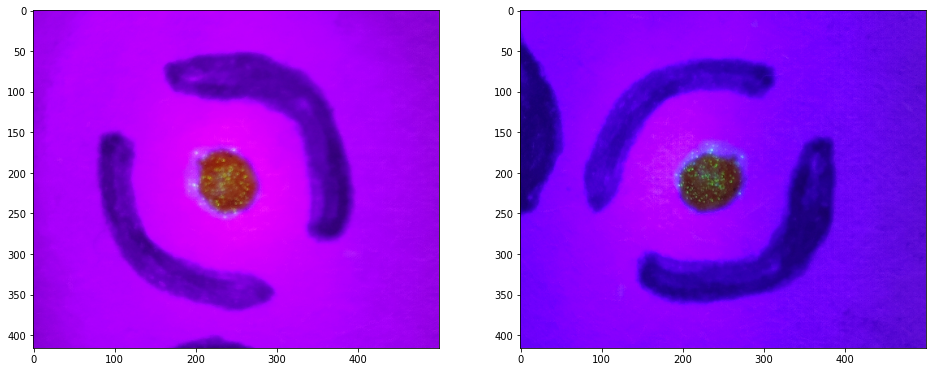

In [9]:
trainImg = imageio.imread('./new labels/1_1.png')
#trainImg = cv2.blur(trainImg, [5,5])
(pix1, pix2) = ( 500, int(len(trainImg)*500/int(len(trainImg[0]))))
trainImg = cv2.resize(trainImg, (pix1, pix2))
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)



queryImg = imageio.imread('./new labels/1_2.png')
queryImg = cv2.resize(queryImg, (pix1, int(pix2*len(queryImg[1])/len(queryImg[0]))))
#queryImg = cv2.blur(queryImg, [5,5])
# Opencv defines the color channel in the order BGR.
# Transform it to RGB to be compatible to matplotlib
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)



fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("", fontsize=14)

plt.show()

# Ищем ключевые точки и вычисляем дексрипторы

In [10]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """

    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"

    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()

    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)

    return (kps, features)

kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)

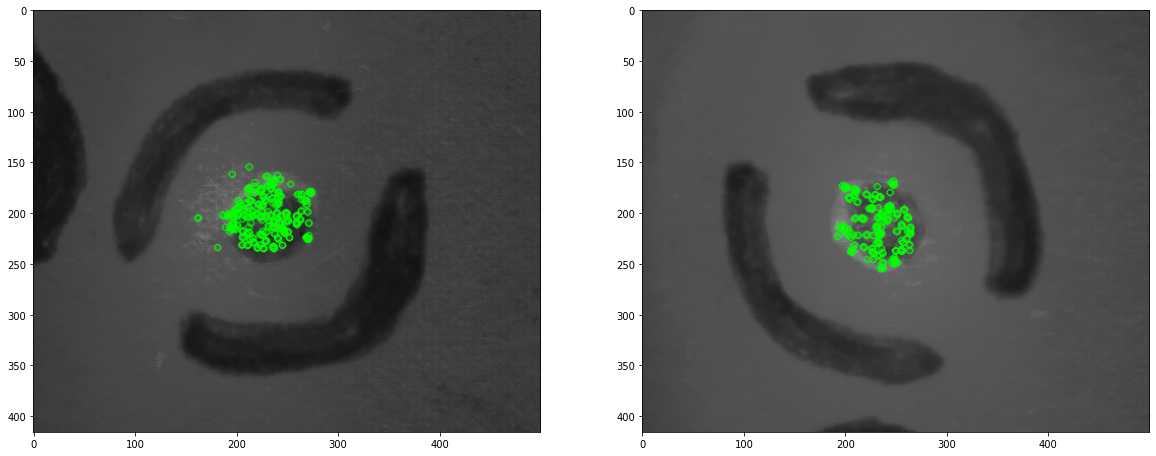

In [12]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("", fontsize=14)

plt.show()

# Ищем похожие дескрипторы

In [13]:

def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"

    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [14]:
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)

    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)

    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

In [15]:

def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Using: bf feature matcher
Raw matches (Brute force): 108


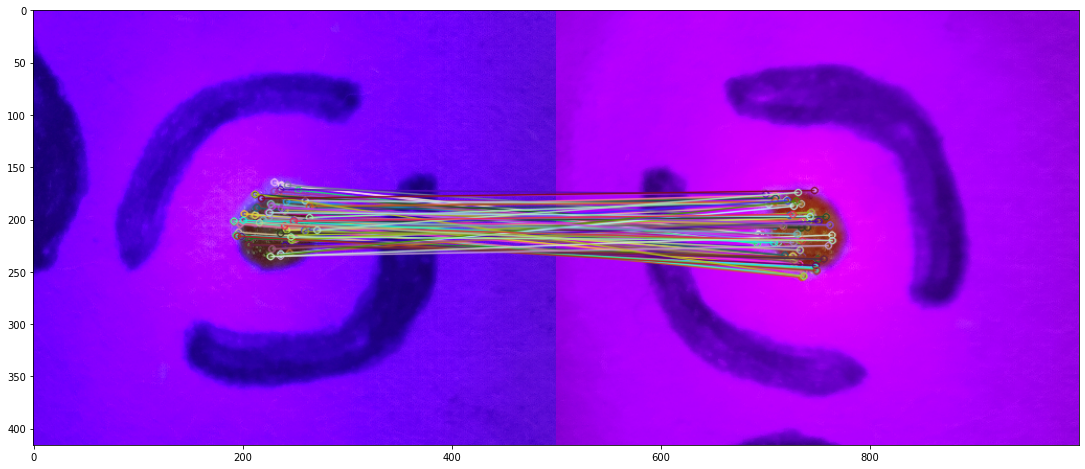

In [16]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':

    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


plt.imshow(img3)
plt.imsave('1.png', img3)
plt.show()

# Сопоставление ключевых точек на изображении

In [17]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])

    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])

        # estimate the homography between the sets of points
        #(H, status) = cv2.estimateAffinePartial2D(ptsA, ptsB)
        (H, status) = cv2. findHomography(ptsA, ptsB, cv2.RANSAC,reprojThresh)

        return (matches, H, status)
    else:
        return None

In [18]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=20)
if M is None:
    print("Error!")
(matches, H, status) = M
print(np.sum(status))
print(len(matches))
print(H)

84
108
[[-2.35469542e-01  1.30788967e+00  4.51376807e+01]
 [-1.16239626e+00  4.18982459e-02  4.98621773e+02]
 [-2.26433758e-04  8.10429098e-04  1.00000000e+00]]


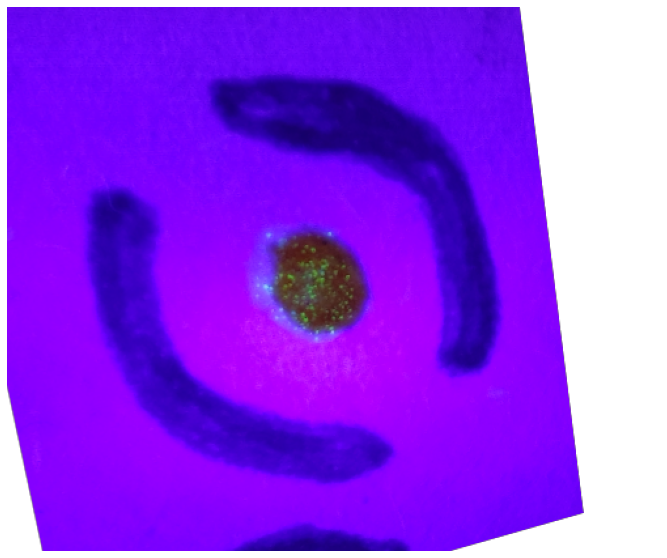

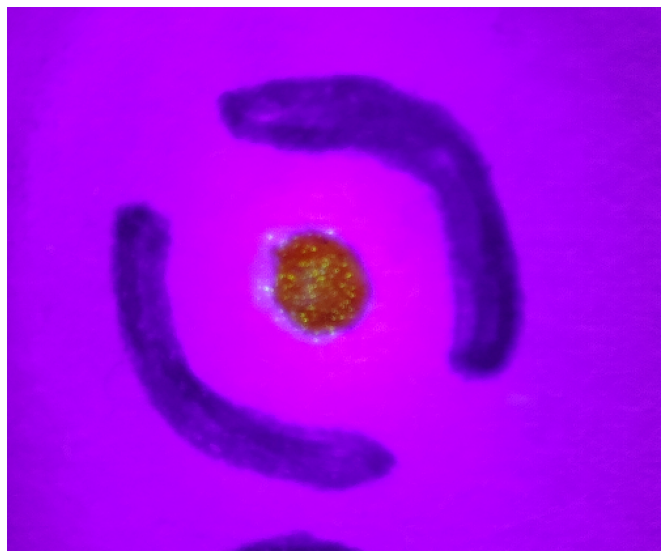

In [19]:
# Apply correction
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]


#result = cv2.warpAffine(trainImg, H,(queryImg.shape[1], queryImg.shape[0]))
result = cv2.warpPerspective(trainImg, H,(queryImg.shape[1], queryImg.shape[0]))

#result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(queryImg)

plt.axis('off')
plt.show()

# Тут код для пробежки по файлам  (Пока лучше не трогать)


In [22]:

def comp(label1, label2):
    trainImg = imageio.imread(label1)
    #trainImg = cv2.blur(trainImg, [5,5])
    (pix1, pix2) = ( 500, int(len(trainImg)*500/int(len(trainImg[0]))))
    trainImg = cv2.resize(trainImg, (pix1, pix2))
    trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)



    queryImg = imageio.imread(label2)
    queryImg = cv2.resize(queryImg, (pix1, int(pix2*len(queryImg[1])/len(queryImg[0]))))
    #queryImg = cv2.blur(queryImg, [5,5])
    # Opencv defines the color channel in the order BGR.
    # Transform it to RGB to be compatible to matplotlib
    queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)


    kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
    kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)

    #print("Using: {} feature matcher".format(feature_matching))

    fig = plt.figure(figsize=(20,8))

    if feature_matching == 'bf':

        matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
        img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                               None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    elif feature_matching == 'knn':
        matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
        img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                               None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


    M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=20)
    if M is None:
        print("Error!")
    (matches, H, status) = M
    #print(np.sum(status))
    #print(len(matches))
    #print(H)

    width = trainImg.shape[1] + queryImg.shape[1]
    height = trainImg.shape[0] + queryImg.shape[0]


    #result = cv2.warpAffine(trainImg, H,(queryImg.shape[1], queryImg.shape[0]))
    result = cv2.warpPerspective(trainImg, H,(queryImg.shape[1], queryImg.shape[0]))

    #result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg
    return np.sum(status), len(matches), H



In [23]:
print(comp('./new labels/1_2.png','./new labels/1_2.png'))

Using: bf feature matcher
Raw matches (Brute force): 237
(237, 237, array([[ 1.00000000e+00, -9.25407693e-16, -6.42980358e-17],
       [ 5.96139394e-16,  1.00000000e+00, -8.08976724e-14],
       [ 3.19853744e-18, -4.02773491e-18,  1.00000000e+00]]))


<Figure size 1440x576 with 0 Axes>

In [30]:
files = os.listdir('./new labels')
same  = []
diff = []
path = './new labels/'

In [31]:
for i in files:
    for j in files:
        if i[:2] == j[:2] and i != j:
            same.append(comp(path + i, path + j))
            print('same', path + i, path + j)
        elif i != j:
            diff.append(comp(path + i, path + j))
            print('diff', path + i, path + j)

Using: bf feature matcher
Raw matches (Brute force): 94
same ./new labels/10_1.png ./new labels/10_2.png
Using: bf feature matcher
Raw matches (Brute force): 133
same ./new labels/10_1.png ./new labels/10_3.png
Using: bf feature matcher
Raw matches (Brute force): 66
diff ./new labels/10_1.png ./new labels/11_1.png
Using: bf feature matcher
Raw matches (Brute force): 66
diff ./new labels/10_1.png ./new labels/11_2.png
Using: bf feature matcher
Raw matches (Brute force): 71
diff ./new labels/10_1.png ./new labels/11_3.png
Using: bf feature matcher
Raw matches (Brute force): 64
diff ./new labels/10_1.png ./new labels/12_1.png
Using: bf feature matcher
Raw matches (Brute force): 65
diff ./new labels/10_1.png ./new labels/12_2.png
Using: bf feature matcher
Raw matches (Brute force): 82
diff ./new labels/10_1.png ./new labels/12_3.png
Using: bf feature matcher
Raw matches (Brute force): 86
diff ./new labels/10_1.png ./new labels/12_4.png
Using: bf feature matcher
Raw matches (Brute force): 8

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

In [53]:
diff0 = [item[0] for item in diff]
same0 = [item[0] for item in same]
diff1 = [item[1] for item in diff]
same1 = [item[1] for item in same]
diff2 = [item[2] for item in diff]
same2 = [item[2] for item in same]


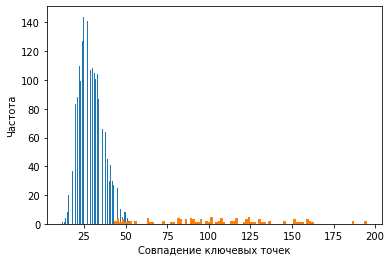

In [60]:
plt.hist(diff0, bins=100)
plt.hist(same0, bins=100)
plt.xlabel('Совпадение ключевых точек')
plt.ylabel('Частота')
plt.show()

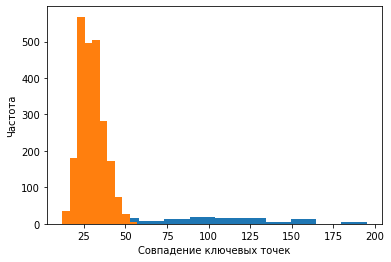

In [59]:
plt.hist(same0)
plt.hist(diff0)

plt.xlabel('Совпадение ключевых точек')
plt.ylabel('Частота')
plt.show()

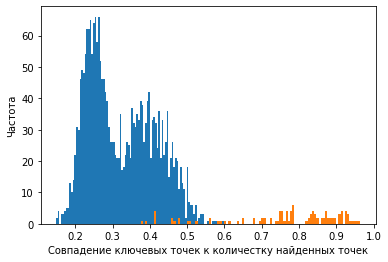

In [61]:
plt.hist(np.array(diff0)/np.array(diff1), bins=100)
plt.hist(np.array(same0)/np.array(same1), bins=100)
plt.xlabel('Совпадение ключевых точек к количестку найденных точек')
plt.ylabel('Частота')
plt.show()